In [1]:
import pandas as pd
import ast
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import json
import numpy as np
import pydicom
import cv2
import os
import re
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## 1. Data Preparation

### Load data

In [2]:
df = pd.read_csv("whole Dataset.csv")

In [3]:
# df[:5]

In [4]:
# print(len(df))

### Remove 34 nodules with missing annotations

In [5]:
# print(df.dtypes)

In [6]:
df["slices_present"] = df["slices_present"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [7]:
length_counts = Counter(len(x) for x in df["slices_present"])
for k in sorted(length_counts):
    print(f"{k} slices: {length_counts[k]} nodules")

0 slices: 34 nodules
1 slices: 18 nodules
2 slices: 239 nodules
3 slices: 376 nodules
4 slices: 196 nodules
5 slices: 163 nodules
6 slices: 142 nodules
7 slices: 123 nodules
8 slices: 88 nodules
9 slices: 50 nodules
10 slices: 15 nodules
11 slices: 16 nodules
12 slices: 6 nodules
13 slices: 12 nodules
14 slices: 7 nodules
18 slices: 1 nodules
19 slices: 1 nodules


In [8]:
df = df[df['slices_present'].apply(lambda x: len(x) > 0)]

In [9]:
print((df['slices_present'].apply(len) == 0).sum())  

0


In [10]:
print(len(df))

1453


### Encoding Labels

In [11]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['nodule_name'])

In [12]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_map)

{'Active Infection': 0, 'Adenocarcinoma': 1, 'Adenoid Cystic Carcinoma': 2, 'Bronchioloalveolar Hyperplasia': 3, 'Carcinoid Tumors': 4, 'Granuloma': 5, 'Hamartoma': 6, 'Intrapulmonary Lymph Nodes': 7, 'Large Cell (Undifferentiated) Carcinoma': 8, 'Lymphoma': 9, 'Metastatic Tumors': 10, 'Sarcoidosis': 11, 'Sarcomatoid Carcinoma': 12, 'Small Cell Lung Cancer (SCLC)': 13, 'Squamous Cell Carcinoma': 14}


NOTE: Long covid is not part of this study

# 2. Volume input preprocessing

For each sample:

- volume_local: cropped region centered around nodule (based on segmentation)

- volume_context: full slice (resized to something like 256×256), no crop

In [13]:
# Parse annotaions for bounding box
def load_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    annotations = data.get("annotation", [])
    return annotations

# Get nodule centroid
def polygon_centroid(norm_polygon, img_shape):
    h, w = img_shape
    x_coords = norm_polygon[::2]
    y_coords = norm_polygon[1::2]
    
    # Convert to pixel space
    x_pixels = [x * w for x in x_coords]
    y_pixels = [y * h for y in y_coords]

    x_center = int(np.mean(x_pixels))
    y_center = int(np.mean(y_pixels))

    return x_center, y_center

# Get local crop and global context
def process_slice_local_context(dcm_path, segmentation, local_size=(64, 64), context_size=(256, 256)):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array
    h, w = img.shape

    # Normalize pixel values
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)

    x_center, y_center = polygon_centroid(segmentation, (h, w))

    # Crop around the center for local view
    half_h, half_w = local_size[0] // 2, local_size[1] // 2
    y1 = max(y_center - half_h, 0)
    y2 = min(y_center + half_h, h)
    x1 = max(x_center - half_w, 0)
    x2 = min(x_center + half_w, w)
    cropped_local = img[y1:y2, x1:x2]

    # Pad if needed
    cropped_local = cv2.resize(cropped_local, local_size)

    # Resize whole slice for context
    resized_context = cv2.resize(img, context_size)

    return cropped_local, resized_context

def remove_leading_duplicate_folder(path):
    """
    Removes the first repeated folder name at the beginning of a path.
    E.g., '../X\\X\\...' → 'X\\...'
    """
    match = re.match(r"^(?:\.\.[\\/])?([^\\/]+)[\\/]\1[\\/](.+)", path)
    if match:
        return f"{match.group(1)}\\{match.group(2)}"
    return path


In [14]:
df['file_path'] = df['file_path'].apply(remove_leading_duplicate_folder)

In [15]:
# Trying with 1 data sample
json_path = df.iloc[0]['file_path'] 

annotations = load_annotations(json_path)

local_slices = []
context_slices = []

for slice_dict in annotations:
    for slice_idx, data in slice_dict.items():
        dcm_filename = os.path.basename(data["dicomFile"])
        dcm_dir = os.path.dirname(json_path)
        dcm_path = os.path.join(dcm_dir, dcm_filename)
        segmentation = data["segmentation"][0]  
        local, context = process_slice_local_context(
            dcm_path, segmentation,
            local_size=(64, 64),
            context_size=(256, 256)
        )
        local_slices.append(local)
        context_slices.append(context)

In [16]:
# Pads or crops a list of 2D slices to a fixed 3D volume.
def pad_or_crop_volume(slices, target_depth, shape):
    D = len(slices)
    h, w = shape

    if D == 0:
        return np.zeros((1, target_depth, h, w), dtype=np.float32)

    volume = np.stack(slices, axis=0)

    if D < target_depth:
        pad_before = (target_depth - D) // 2
        pad_after = target_depth - D - pad_before
        volume = np.pad(volume, ((pad_before, pad_after), (0, 0), (0, 0)), mode='constant')
    elif D > target_depth:
        start = (D - target_depth) // 2
        volume = volume[start:start+target_depth]

    return volume[None, ...]  # Add channel dim: [1, D, H, W]


In [17]:
volume_local = pad_or_crop_volume(local_slices, target_depth=5, shape=(64, 64))
volume_context = pad_or_crop_volume(context_slices, target_depth=7, shape=(256, 256))

print("volume_local shape:", volume_local.shape)
print("volume_context shape:", volume_context.shape)

volume_local shape: (1, 5, 64, 64)
volume_context shape: (1, 7, 256, 256)


In [18]:
# Applying to entire dataset
all_locals = []
all_contexts = []
all_labels = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing samples"):
    try:
        json_path = row['file_path']
        label = row['label']
        annotations = load_annotations(json_path)

        local_slices = []
        context_slices = []

        for slice_dict in annotations:
            for slice_idx, data in slice_dict.items():
                
                dcm_filename = os.path.basename(data["dicomFile"])
                dcm_dir = os.path.dirname(json_path)
                dcm_path = os.path.join(dcm_dir, dcm_filename)

                segmentation = data["segmentation"][0]
                local, context = process_slice_local_context(
                    dcm_path, segmentation,
                    local_size=(64, 64),
                    context_size=(256, 256)
                )
                local_slices.append(local)
                context_slices.append(context)

        volume_local = pad_or_crop_volume(local_slices, target_depth=5, shape=(64, 64))
        volume_context = pad_or_crop_volume(context_slices, target_depth=7, shape=(256, 256))

        all_locals.append(volume_local)
        all_contexts.append(volume_context)
        all_labels.append(label)

    except Exception as e:
        print(f"Skipping row due to error: {e}")


Processing samples: 100%|██████████| 1453/1453 [00:18<00:00, 76.56it/s]


# 3. Radiomics preparation

In [19]:
radiomics_columns = [
    "calcification", "internal_structure", "lobulation",
    "margin", "sphericity", "texture"
]

In [20]:
radiomics_df = df[radiomics_columns].copy()

In [21]:
radiomics_encoded = pd.get_dummies(radiomics_df, drop_first=False)

In [22]:
print("Radiomics vector shape:", radiomics_encoded.shape)
radiomics_encoded.head()

Radiomics vector shape: (1453, 25)


,calcification_Absent,calcification_Central,calcification_Laminated,calcification_Non-Central,calcification_Popcorn,calcification_Solid,internal_structure_Soft Tissue,lobulation_Marked,lobulation_N-Marked,lobulation_Nn-Mk,...,margin_Sharp,sphericity_Lin-Ov,sphericity_Linear,sphericity_Ov-Ro,sphericity_Ovoid,sphericity_Round,texture_NS-PS,texture_PS-Solid,texture_Part Solid/Mixed,texture_Solid
0,True,False,False,False,False,False,True,False,False,True,...,False,True,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False
2,True,False,False,False,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,False,False
3,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,True,False,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True


In [23]:
X_radiomics = radiomics_encoded.to_numpy(dtype=np.float32)

In [24]:
X_radiomics.shape

(1453, 25)

# 4. Create Pytorch Dataset

In [25]:
class TripleFusionDataset(Dataset):
    def __init__(self, all_locals, all_contexts, X_radiomics, labels_df):
        self.all_locals = all_locals
        self.all_contexts = all_contexts
        self.radiomics = X_radiomics
        self.labels = labels_df["label"].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            "volume_local": torch.tensor(self.all_locals[idx], dtype=torch.float32),
            "volume_context": torch.tensor(self.all_contexts[idx], dtype=torch.float32),
            "radiomics": torch.tensor(self.radiomics[idx], dtype=torch.float32),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }
        return sample


In [26]:
dataset = TripleFusionDataset(
    all_locals=all_locals,
    all_contexts=all_contexts,
    X_radiomics=X_radiomics,
    labels_df=df  
)

In [27]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 5. Triple Fusion Architecture


| Branch           | Input Shape           | Type     |
|------------------|------------------------|----------|
| `volume_local`   | `[B, 1, 5, 64, 64]`     | 3D CNN   |
| `volume_context` | `[B, 1, 7, 256, 256]`   | 3D CNN   |
| `radiomics`      | `[B, 25]`               | MLP      |


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import r3d_18

### Local Branch

In [29]:
class LocalBranch(nn.Module):
    def __init__(self):
        super(LocalBranch, self).__init__()
        self.backbone = r3d_18(weights=None)
        self.backbone.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)  # Output: [B, 512]

### Context Branch

In [30]:
class ContextBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = r3d_18(weights=None)
        self.backbone.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)  # Output: [B, 512]

### Radiomics Branch

In [31]:
class RadiomicsBranch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.fc(x)  # Output: [B, 32]

In [32]:
class AttentionFusion(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attn(x)
        return x * weights  # Element-wise attention

### Fusion Model

In [33]:
class TripleFusionModel(nn.Module):
    def __init__(self, num_classes, radiomics_dim=25):
        super().__init__()
        self.local_branch = LocalBranch()
        self.context_branch = ContextBranch()
        self.radiomics_branch = RadiomicsBranch(radiomics_dim)
        self.attn_fusion = AttentionFusion(512 + 512 + 32)

        self.classifier = nn.Sequential(
            nn.Linear(512 + 512 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, volume_local, volume_context, radiomics):
        local_feat = self.local_branch(volume_local)        # [B, 512]
        context_feat = self.context_branch(volume_context)  # [B, 512]
        radio_feat = self.radiomics_branch(radiomics)       # [B, 32]

        fused = torch.cat([local_feat, context_feat, radio_feat], dim=1)  # [B, 1056]
        fused_attn = self.attn_fusion(fused)  # Apply attention weights
        out = self.classifier(fused_attn)
        return out

# 6. Training

In [34]:
num_classes = len(df["label"].unique())
model = TripleFusionModel(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [35]:
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

In [36]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        start_time = time.time()

        vol_local = batch["volume_local"].to(device)
        vol_context = batch["volume_context"].to(device)
        radiomics = batch["radiomics"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(vol_local, vol_context, radiomics)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = compute_accuracy(outputs, labels)
        batch_time = time.time() - start_time

        total_loss += loss.item()
        total_acc += acc

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{acc:.4f}",
            "time": f"{batch_time:.2f}s"
        })

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [37]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    pbar = tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar:
            vol_local = batch["volume_local"].to(device)
            vol_context = batch["volume_context"].to(device)
            radiomics = batch["radiomics"].to(device)
            labels = batch["label"].to(device)

            outputs = model(vol_local, vol_context, radiomics)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_loss += loss.item()
            total_acc += acc

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc:.4f}"
            })

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
all_indices = np.arange(len(dataset))

train_idx, temp_idx = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [40]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

Epoch 1/10
  Train Loss: 2.4389 | Accuracy: 0.1729
  Val   Loss: 2.1460 | Accuracy: 0.2105


Epoch 2/10
  Train Loss: 1.9485 | Accuracy: 0.2474
  Val   Loss: 1.8291 | Accuracy: 0.2895


Epoch 3/10
  Train Loss: 1.8217 | Accuracy: 0.3202
  Val   Loss: 2.0297 | Accuracy: 0.3750


Epoch 4/10
  Train Loss: 1.7625 | Accuracy: 0.3527
  Val   Loss: 1.6641 | Accuracy: 0.3224


Epoch 5/10
  Train Loss: 1.6627 | Accuracy: 0.3707
  Val   Loss: 1.5617 | Accuracy: 0.4013


Epoch 6/10
  Train Loss: 1.5712 | Accuracy: 0.4075
  Val   Loss: 1.5675 | Accuracy: 0.4211


Epoch 7/10
  Train Loss: 1.4548 | Accuracy: 0.4777
  Val   Loss: 1.4948 | Accuracy: 0.5066


Epoch 8/10
  Train Loss: 1.4328 | Accuracy: 0.4837
  Val   Loss: 1.5372 | Accuracy: 0.4408


Epoch 9/10
  Train Loss: 1.3348 | Accuracy: 0.4966
  Val   Loss: 1.3192 | Accuracy: 0.5000


Epoch 10/10
  Train Loss: 1.2971 | Accuracy: 0.5223
  Val   Loss: 1.3983 | Accuracy: 0.5263


In [41]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

Epoch 1/10
  Train Loss: 1.2278 | Accuracy: 0.5394
  Val   Loss: 1.3368 | Accuracy: 0.5263


Epoch 2/10
  Train Loss: 1.1618 | Accuracy: 0.5659
  Val   Loss: 1.3781 | Accuracy: 0.5461


Epoch 3/10
  Train Loss: 1.1537 | Accuracy: 0.5651
  Val   Loss: 1.2721 | Accuracy: 0.5526


Epoch 4/10
  Train Loss: 1.1031 | Accuracy: 0.6053
  Val   Loss: 1.3620 | Accuracy: 0.5461


Epoch 5/10
  Train Loss: 1.0514 | Accuracy: 0.6070
  Val   Loss: 1.3017 | Accuracy: 0.5658


Epoch 6/10
  Train Loss: 1.0436 | Accuracy: 0.6045
  Val   Loss: 1.3539 | Accuracy: 0.5789


Epoch 7/10
  Train Loss: 0.9958 | Accuracy: 0.6284
  Val   Loss: 1.2633 | Accuracy: 0.5855


Epoch 8/10
  Train Loss: 1.0294 | Accuracy: 0.6207
  Val   Loss: 1.3069 | Accuracy: 0.5658


Epoch 9/10
  Train Loss: 0.9295 | Accuracy: 0.6789
  Val   Loss: 1.2253 | Accuracy: 0.6118


Epoch 10/10
  Train Loss: 0.8702 | Accuracy: 0.6849
  Val   Loss: 1.2375 | Accuracy: 0.5921


In [42]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

Epoch 1/10
  Train Loss: 0.8334 | Accuracy: 0.7021
  Val   Loss: 1.2893 | Accuracy: 0.6184


Epoch 2/10
  Train Loss: 0.8077 | Accuracy: 0.6952
  Val   Loss: 1.2560 | Accuracy: 0.6382


Epoch 3/10
  Train Loss: 0.7738 | Accuracy: 0.7140
  Val   Loss: 1.4313 | Accuracy: 0.5789


Epoch 4/10
  Train Loss: 0.7475 | Accuracy: 0.7260
  Val   Loss: 1.5295 | Accuracy: 0.6184


Epoch 5/10
  Train Loss: 0.6615 | Accuracy: 0.7594
  Val   Loss: 1.3699 | Accuracy: 0.6118


Epoch 6/10
  Train Loss: 0.6620 | Accuracy: 0.7440
  Val   Loss: 1.5617 | Accuracy: 0.5658


Epoch 7/10
  Train Loss: 0.6348 | Accuracy: 0.7688
  Val   Loss: 1.3740 | Accuracy: 0.6053


Epoch 8/10
  Train Loss: 0.5483 | Accuracy: 0.7971
  Val   Loss: 1.6611 | Accuracy: 0.5592


Epoch 9/10
  Train Loss: 0.5536 | Accuracy: 0.7962
  Val   Loss: 1.3073 | Accuracy: 0.6118


Epoch 10/10
  Train Loss: 0.5429 | Accuracy: 0.8057
  Val   Loss: 1.4665 | Accuracy: 0.5921


# 7. Evaluation

NOTE: I forgot to do a test dataset split so I'm currently gonna get a random subset

In [43]:
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            vol_local = batch["volume_local"].to(device)
            vol_context = batch["volume_context"].to(device)
            radiomics = batch["radiomics"].to(device)
            labels = batch["label"].to(device)

            outputs = model(vol_local, vol_context, radiomics)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [44]:
def evaluate_model(model, dataloader, device, class_names):
    y_pred, y_true = predict(model, dataloader, device)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Accuracy: 0.6575
F1 Score: 0.6594

Classification Report:
                                         precision    recall  f1-score   support

                       Active Infection       0.58      0.70      0.64        10
                         Adenocarcinoma       0.67      0.22      0.33         9
               Adenoid Cystic Carcinoma       0.67      0.22      0.33         9
         Bronchioloalveolar Hyperplasia       0.55      0.65      0.59        17
                       Carcinoid Tumors       1.00      0.91      0.95        11
                              Granuloma       0.86      0.95      0.90        20
                              Hamartoma       1.00      1.00      1.00         5
             Intrapulmonary Lymph Nodes       1.00      0.88      0.93         8
Large Cell (Undifferentiated) Carcinoma       0.20      0.38      0.26         8
                               Lymphoma       0.86      0.60      0.71        10
                      Metastatic Tumors       0.71

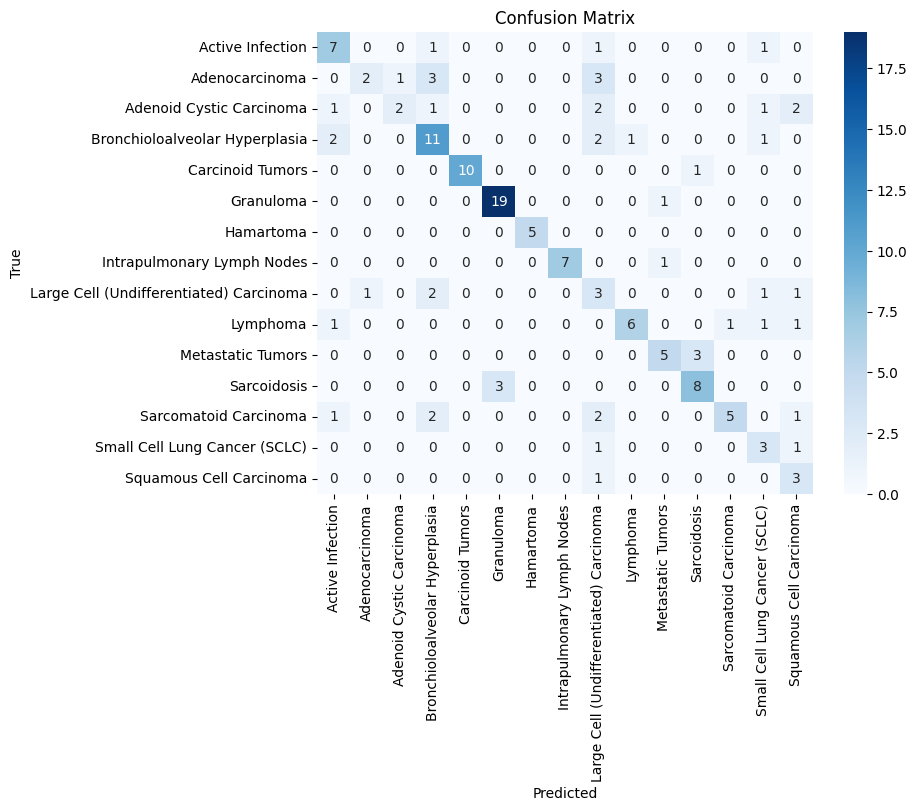

In [45]:
class_names = list(le.classes_)
evaluate_model(model, test_loader, device, class_names)

# 8. Explainability

### Grad-Cam

In [48]:
target_layer = model.local_branch.backbone.layer1[0].conv2  # the second Conv3D layer

In [49]:
cam = GradCAM(model=model.local_branch, target_layers=[target_layer])

batch = next(iter(test_loader))  # one batch
input_tensor = batch["volume_local"][0].unsqueeze(0).to(device)  # [1, 1, D, H, W]
target_category = batch["label"][0].item()

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])

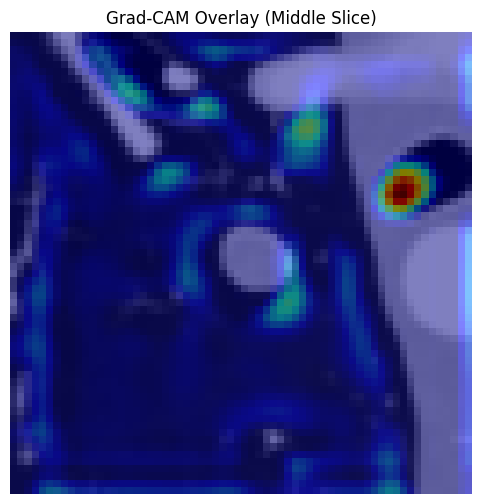

In [50]:
# Visualize the heatmap 
input_volume = batch["volume_local"][0].squeeze(0).cpu().numpy() 

def normalize(x):
    x = x - x.min()
    x = x / (x.max() + 1e-5)
    return x

volume = batch["volume_local"][0].squeeze(0).cpu().numpy()      
grayscale = grayscale_cam[0]                                    

# Take the middle slice
mid = volume.shape[0] // 2
slice_img = normalize(volume[mid])
cam_slice = normalize(grayscale[mid])

if cam_slice.shape != slice_img.shape:
    cam_slice = cv2.resize(cam_slice, slice_img.shape[::-1])

# Convert CAM to heatmap
cam_uint8 = np.ascontiguousarray((cam_slice * 255).astype(np.uint8))
heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

# Prepare grayscale CT image
ct_rgb = np.stack([slice_img] * 3, axis=-1)

overlay = 0.5 * ct_rgb + 0.5 * heatmap

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Grad-CAM Overlay (Middle Slice)")
plt.axis("off")
plt.show()

# 9. Save model

In [51]:
torch.save(model.state_dict(), "triple_fusion_model.pkl")